# [GD-02]WordDictionary

## 라이브러리 버전 확인

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.22.2
3.4.3
0.5.2


## SentencePiece 설치하기

In [2]:
# !pip install sentencepiece

## SentencePiece 모델 학습

In [3]:
# 이전 스텝 
# filtered_corpus를 위한 요약

import os
import numpy as np
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f: 
    raw = f.read().splitlines() # 줄 단위로 읽어봅시다.

In [4]:
min_len = 999
max_len = 0

for sen in raw:
    length = len(sen)
    
    # 문장 최소 길이 찾기
    if min_len > length: 
        min_len = length
    
    # 문장 최대 길이 찾기
    if max_len < length: 
        max_len = length
        
    
sentence_length = np.zeros((max_len), dtype=np.int)

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

/tmp/ipykernel_654/1943799563.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


In [5]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.
# input: 입력 corpus
# prefix: 저장할 모델 이름
# vocab_size: vocab 개수 (기본 8,000)


!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376725 Mar 23 09:22 korean_spm.model
-rw-r--r-- 1 root root 146094 Mar 23 09:22 korean_spm.vocab


SentencePiece 모델 학습이 완료된 후 koreanspm.model 파일과 koreanspm.vocab vocabulary 파일이 생성되었음을 확인

In [6]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1255, 11, 304, 7, 3606, 11, 285, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## Tokenizer 함수 작성

In [7]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))   # 숫자로 임베딩

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]  
        
        word_index.update({idx:word})   # 생성된 vocab 파일을 읽어와 { : } 형태를 가지는 word_index 사전과 
        index_word.update({word:idx})   # { : } 형태를 가지는 index_word 사전을 생성하고 함께 반환

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [8]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1957 5607    5    4 7975 2012    3    0    0    0    0    0    0    0]
 [ 108 1658  101    4    0  470   11    4   14    0 2002    3    3    3]]


## 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

### 데이터 불러오기

In [9]:
# !git clone https://github.com/e9t/nsmc.git

In [10]:
os.listdir('nsmc')

['synopses.json',
 'ratings.txt',
 'ratings_test.txt',
 'README.md',
 'raw',
 'code',
 '.git',
 'ratings_train.txt']

In [11]:
import pandas as pd
train_data = pd.read_table("nsmc/"+"ratings_train.txt")
test_data = pd.read_table("nsmc/"+"ratings_test.txt")

display(train_data.head())
display(test_data.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 데이터 전처리

In [12]:
print("학습데이터 유니크 :",train_data['document'].nunique()) #  약 4,000개의 중복 샘플이 존재
print("타겟데이터 유니크 : ",train_data['label'].nunique())

학습데이터 유니크 : 146182
타겟데이터 유니크 :  2


In [13]:
# 중복데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True) # drop_duplicates 활용

In [14]:
# 학습데이터 개수 다시 확인
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


In [15]:
# document에 null 값이 있는지 확인
print(train_data.isnull().values.any())

True


In [16]:
# 어느 위치에 누락값이 있는지 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [17]:
# Null값 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [18]:
# 데이터 전처리
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
train_data[:5]

/tmp/ipykernel_654/789371173.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
# 바뀐 데이터 내부에 null값이 있는지 다시 확인

# white space 데이터를 empty value로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "") 
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/tmp/ipykernel_654/1591183560.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


In [20]:
# null 데이터 삭제
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [21]:
# 테스트데이터에도 동일한 과정 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/tmp/ipykernel_654/3707744765.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_654/3707744765.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [22]:
# 데이터 확인
train_data.info()
print("="*50)
test_data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145393 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145393 non-null  int64 
 1   document  145393 non-null  object
 2   label     145393 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48852 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48852 non-null  int64 
 1   document  48852 non-null  object
 2   label     48852 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [23]:
# 데이터 확인
display(train_data.head())
display(test_data.head())

print("훈련데이터 : ",len(train_data))
print("테스트데이터 : ",len(test_data))

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


,id,document,label
0,6270596,굳 ㅋ,1
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,7898805,음악이 주가 된 최고의 음악영화,1


훈련데이터 :  145393
테스트데이터 :  48852


문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 33
sentence_length :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/tmp/ipykernel_654/2857138701.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


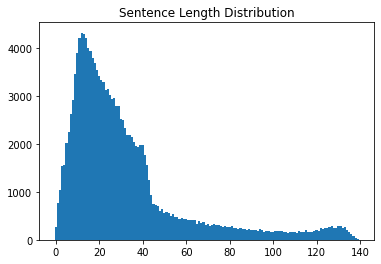

In [24]:
# 데이터 길이 분포 확인하기
import matplotlib.pyplot as plt

min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    
    # 문장 최소 길이 찾기
    if min_len > length: 
        min_len = length
    
    # 문장 최대 길이 찾기
    if max_len < length: 
        max_len = length
        
    # 전체 문장을 합치면 길이가 얼마나 될까요?
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

# 전체 길이만큼 0벡터 ==> 길이에 따른 문장의 수를 저장하기 위해 먼저 0으로 이루어진 리스트를 만든다!!
sentence_length = np.zeros((max_len), dtype=np.int)
print("sentence_length : ",sentence_length)

print("="*60)

# raw는 위에서 다운로드한 데이터셋!! 전체 길이와 상관없음
for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1 # 0으로 이루어진 벡터에 문장 count를 더한 뒤 넣는다.

plt.bar(range(max_len), sentence_length, width=1.0) # 너비는 1.0씩 늘어나도록 설정
plt.title("Sentence Length Distribution")
plt.show()

#### -> 40 이하 데이터 활용

In [25]:
# 길이 40이하로 한정해 데이터를 만듭니다.

# 이렇게 하면 document 내용만 list로 전달됨 
train_list = [s for s in train_data['document'] if (len(s) <= 40)]
test_list = [s for s in test_data['document'] if (len(s) <= 40)]

train_list = list(set(train_list))
test_list = list(set(test_list))

train_df = pd.DataFrame(train_list)
test_df = pd.DataFrame(test_list)

In [26]:
# 길이 40이하인 데이터를 기존 데이터와 병합합니다.

new_train_df = pd.merge(train_data, train_df, how='inner', left_on='document', right_on=0)
new_test_df = pd.merge(test_data, test_df, how='inner', left_on='document', right_on=0)

train_data = new_train_df[['id', 'document', 'label']]
test_data = new_test_df[['id', 'document', 'label']]

In [27]:
display(train_data.head())
display(test_data.head())

print("훈련데이터 : ",len(train_data))
print("테스트데이터 : ",len(test_data))

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0


,id,document,label
0,6270596,굳 ㅋ,1
1,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
3,7898805,음악이 주가 된 최고의 음악영화,1
4,6315043,진정한 쓰레기,0


훈련데이터 :  110924
테스트데이터 :  37291


In [28]:
# document와 label을 나눠봅시다.
X_train,X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
X_test,X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])
# 현재 list 상태 ==> ndarray로 바꿔주기
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [29]:
print(X_train[:3])
print(X_test[:3])

[[ 138  106 2662  918 4930    4 4930  839   69  553  517 2630    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   4 7660  465 1773  144   14  440 3232 2763 1800  177  410  394   41
  4251    4   11 7571   29 2410  242   69    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1343  444    0  257  229  585   94  144   10 1978    5  999  640  245
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
[[   4 7889    4    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   4 7826  165   25 1105  349  107  180 5502  162 4305  645    4 3412
    10  106  381 7630 2509    0   89    0    0    0    0    0    0    0
     0    0    0    0    0 

In [30]:
print(y_train[:3])
print(y_test[:3])

[0 1 0]
[1 0 0]


In [31]:
print("학습데이터 :",len(X_train))
print("타겟데이터 :",len(y_train))

학습데이터 : 110924
타겟데이터 : 110924


### 훈련데이터와 검증데이터 분리

In [32]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [33]:
print(train_input[:3])
print(val_input[:3])

[[3534   11 2913    6   59  698    6 5136   24  174   65 2981  114  906
     5 1565 6182   31 1610  560  680    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1545  358  916   30 6371   30  818  105   30 2313 7899   30  629  347
  7988   38    4   27  147   27  988   39  637   29  211   14 2082 6046
    29    0    0    0    0    0    0    0    0    0    0    0]
 [ 219 4178  248    4 2428   42    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
[[3135   52    7 3346   65  844   16 1861  214 6656  348 4140  453    4
  3475  253 5466   17 2918  136   11    4 7440  144  525    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2791 3420   17 3795 1076   24  742  342    5 2511 6683 2231  210    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 

In [34]:
# 패딩 맞추기
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=40, padding='post')
val_seq = pad_sequences(val_input, maxlen=40, padding='post')
print(train_seq[:3])
print(val_seq[:3])

[[3534   11 2913    6   59  698    6 5136   24  174   65 2981  114  906
     5 1565 6182   31 1610  560  680    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1545  358  916   30 6371   30  818  105   30 2313 7899   30  629  347
  7988   38    4   27  147   27  988   39  637   29  211   14 2082 6046
    29    0    0    0    0    0    0    0    0    0    0    0]
 [ 219 4178  248    4 2428   42    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
[[3135   52    7 3346   65  844   16 1861  214 6656  348 4140  453    4
  3475  253 5466   17 2918  136   11    4 7440  144  525    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2791 3420   17 3795 1076   24  742  342    5 2511 6683 2231  210    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 

In [35]:
# 순환신경망 모델 선언

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(8000,16))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 128,881
Trainable params: 128,881
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.fit(train_input, 
          train_target, 
          epochs=10, 
          validation_data=(val_input, val_target))

Epoch 1/10
2774/2774 [==============================] - 59s 20ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 2/10
2774/2774 [==============================] - 57s 20ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 3/10
2774/2774 [==============================] - 57s 20ms/step - loss: 0.6878 - accuracy: 0.5125 - val_loss: 0.6201 - val_accuracy: 0.6496
Epoch 4/10
2774/2774 [==============================] - 57s 21ms/step - loss: 0.5131 - accuracy: 0.7542 - val_loss: 0.4333 - val_accuracy: 0.7952
Epoch 5/10
2774/2774 [==============================] - 56s 20ms/step - loss: 0.4064 - accuracy: 0.8159 - val_loss: 0.4239 - val_accuracy: 0.8047
Epoch 6/10
2774/2774 [==============================] - 57s 20ms/step - loss: 0.3756 - accuracy: 0.8294 - val_loss: 0.4049 - val_accuracy: 0.8153
Epoch 7/10
2774/2774 [==============================] - 57s 20ms/step - loss: 0.3512 - accuracy: 0.8425 - val_loss: 0.3954 -

In [38]:
result = model.evaluate(X_test,  y_test, verbose=2)
print(result)


1166/1166 - 5s - loss: 0.4298 - accuracy: 0.8201
[0.4298189580440521, 0.8200638294219971]


### SentencePiece의 다른 옵션의 경우와 비교하여 분석¶

In [39]:
# 1. 모델 하이퍼 파라미터를 바꿔서 성능 비교

vocab_size = 10000

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,100))
model.add(keras.layers.LSTM(128)) # LSTM 레이어 증가
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


In [41]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping과 CheckPoint 사용하여 과적합 방지
es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   verbose=1, 
                   patience=4)
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

# 모델 하이퍼 파라미터 설정
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(train_input, 
                    train_target, 
                    epochs=20, 
                    callbacks=[es, mc], 
                    batch_size=60, 
                    validation_data=(val_input, val_target))

Epoch 1/20
1479/1479 [==============================] - 165s 111ms/step - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.4970

Epoch 00001: val_acc improved from -inf to 0.49696, saving model to best_model.h5
Epoch 2/20
1479/1479 [==============================] - 164s 111ms/step - loss: 0.6932 - acc: 0.4986 - val_loss: 0.6934 - val_acc: 0.4970

Epoch 00002: val_acc did not improve from 0.49696
Epoch 3/20
1479/1479 [==============================] - 166s 112ms/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.4970

Epoch 00003: val_acc did not improve from 0.49696
Epoch 4/20
1479/1479 [==============================] - 165s 111ms/step - loss: 0.6915 - acc: 0.5069 - val_loss: 0.6439 - val_acc: 0.6524

Epoch 00004: val_acc improved from 0.49696 to 0.65242, saving model to best_model.h5
Epoch 5/20
1479/1479 [==============================] - 164s 111ms/step - loss: 0.6829 - acc: 0.5474 - val_loss: 0.6752 - val_acc: 0.5881

Epoch 00005: val_acc did not improve f

In [42]:
# 가장 좋았던 모델 불러오기
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1166/1166 [==============================] - 27s 23ms/step - loss: 0.6439 - acc: 0.6516

 테스트 정확도: 0.6516


In [43]:
# 리뷰 예측 함수
def sentiment_predict(new_sentence):
    s = spm.SentencePieceProcessor()
    s.Load('korean_spm.model')
    tensor = []
    tensor.append(s.EncodeAsIds(new_sentence))
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    score = float(loaded_model.predict(tensor)) # 학습된 모델을 기반으로 인풋으로 들어온 모델을 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [44]:
sentiment_predict("재미있음")

50.07% 확률로 긍정 리뷰입니다.



In [45]:
sentiment_predict("재미없음")

50.41% 확률로 부정 리뷰입니다.



# 회고

LSTM학습모델 : loss 0.43 accuracy 0.82  
LSTM학습모델 하이퍼파라미터 변경 : loss 0.64 accuracy 0.65  
하이퍼파라미터 변경은 큰 영향을 주지않았다.  

예측확률이 생각보다 좋지않다.  
짧은 리뷰들도 전처리로 정리 한 후 학습하면 더 좋아질 것으로 예상한다.  
mecab 토크나이저를 사용하면 또 다른 결과가 나올 것이다.  

[참고블로그](https://piaojian.tistory.com/35)